In [1]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import models

In [2]:
# Definir las transformaciones de preprocesado de las imágenes para validación
transform_val = transforms.Compose(
    [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
    ]
)

In [3]:
# Cargar el dataset de validación
val_dataset = datasets.ImageFolder(
    "../models_generator/dataset/validation", transform=transform_val
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Ver el tamaño del dataset y las clases
print(f"Dataset de validación cargado con {len(val_dataset)} imágenes.")
print(f"Clases encontradas: {val_dataset.classes}")

# Obtener los nombres de las clases
class_names = val_dataset.classes

Dataset de validación cargado con 1500 imágenes.
Clases encontradas: ['Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial', 'Inside city', 'Kitchen', 'Living room', 'Mountain', 'Office', 'Open country', 'Store', 'Street', 'Suburb', 'Tall building']


In [4]:
def evaluate(model, valid_loader, criterion, num_classes):
    """
    Evalúa el rendimiento del modelo en un conjunto de datos de validación y calcula la precisión por clase.

    Parámetros:
    - model (torch.nn.Module): Modelo a evaluar.
    - valid_loader (torch.utils.data.DataLoader): Dataloader con los datos de validación.
    - criterion (torch.nn.Module): Función de pérdida.
    - num_classes (int): Número total de clases en el dataset.

    Retorna:
    - avg_loss (float): Pérdida promedio en el conjunto de validación.
    - accuracy (float): Precisión global del modelo.
    - class_accuracies (dict): Precisión por cada clase.
    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Inicializar contadores para la precisión por clase
    correct_per_class = torch.zeros(num_classes)
    total_per_class = torch.zeros(num_classes)

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)  # Resultados del modelo
            loss = criterion(outputs, labels)  # Calcular la pérdida
            running_loss += loss.item()  # Acumular pérdida

            _, predicted = torch.max(outputs, 1)  # Obtener la clase predicha
            correct_predictions += (predicted == labels).sum().item()  # Contar aciertos
            total_predictions += labels.size(0)  # Total de muestras evaluadas

            # Calcular precisión por clase
            for i in range(labels.size(0)):
                label = labels[i].item()
                total_per_class[label] += 1
                if predicted[i] == label:
                    correct_per_class[label] += 1

    # Calcular métricas
    avg_loss = running_loss / len(valid_loader)
    accuracy = 100 * correct_predictions / total_predictions

    # Calcular accuracy por clase
    class_accuracies = {
        class_names[i]: (
            (100 * correct_per_class[i] / total_per_class[i]).item()
            if total_per_class[i] > 0
            else 0.0
        )
        for i in range(num_classes)
    }

    return avg_loss, accuracy, class_accuracies

In [ ]:
def load_model(model_name, model_path, num_classes):
    print(f"Cargando el modelo: {model_name}")  # Agrega este print para depuración

    # Cargar el modelo base según el nombre proporcionado
    if model_name == "efficientnet_rank_0":
        base_model = models.efficientnet_b0(weights="IMAGENET1K_V1")
    elif model_name == "efficientnet_rank_7":
        base_model = models.efficientnet_b7(weights="DEFAULT")
    elif model_name == "convnext_large_1_epoch":
        base_model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.IMAGENET1K_V1)
    elif model_name == "convnext_large_epoch_3":
        base_model = models.convnext_large(weights=models.ConvNeXt_Large_Weights.DEFAULT)
    else:
        raise ValueError(f"Modelo no soportado: {model_name}")

    # Modificar la capa de salida para adaptarse al número de clases
    if model_name in ["efficientnet_rank_0", "efficientnet_rank_7"]:
        base_model.classifier[1] = nn.Linear(
            base_model.classifier[1].in_features, num_classes
        )
    elif model_name == "convnext_large_1_epoch":
        in_features = base_model.classifier[-1].in_features
        classifier = torch.nn.Sequential(
        torch.nn.Linear(in_features, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.2),
        torch.nn.Linear(512, num_classes)
        )
        base_model.classifier[-1] = classifier

    elif model_name == "convnext_large_epoch_3":
        base_model.classifier[2] = nn.Linear(base_model.classifier[2].in_features, num_classes)
    else:
        raise ValueError(f"Modelo no soportado: {model_name}")

    # Cargar los pesos entrenados previamente
    try:
        state_dict = torch.load(model_path, map_location=torch.device("cpu"))
        base_model.load_state_dict(state_dict, strict=False)
        base_model.eval()
        return base_model
    except Exception as e:
        print(f"Error al cargar el modelo: {e}")
        return None



Evaluando el modelo: convnext_large_1_epoch.pth
Cargando el modelo: convnext_large_1_epoch
Loss promedio: 0.3793
Precisión global: 89.13%
Precisión por clase:
Bedroom: 86.00%
Coast: 87.00%
Forest: 83.00%
Highway: 100.00%
Industrial: 91.00%
Inside city: 78.00%
Kitchen: 82.00%
Living room: 88.00%
Mountain: 93.00%
Office: 85.00%
Open country: 84.00%
Store: 96.00%
Street: 96.00%
Suburb: 97.00%
Tall building: 91.00%


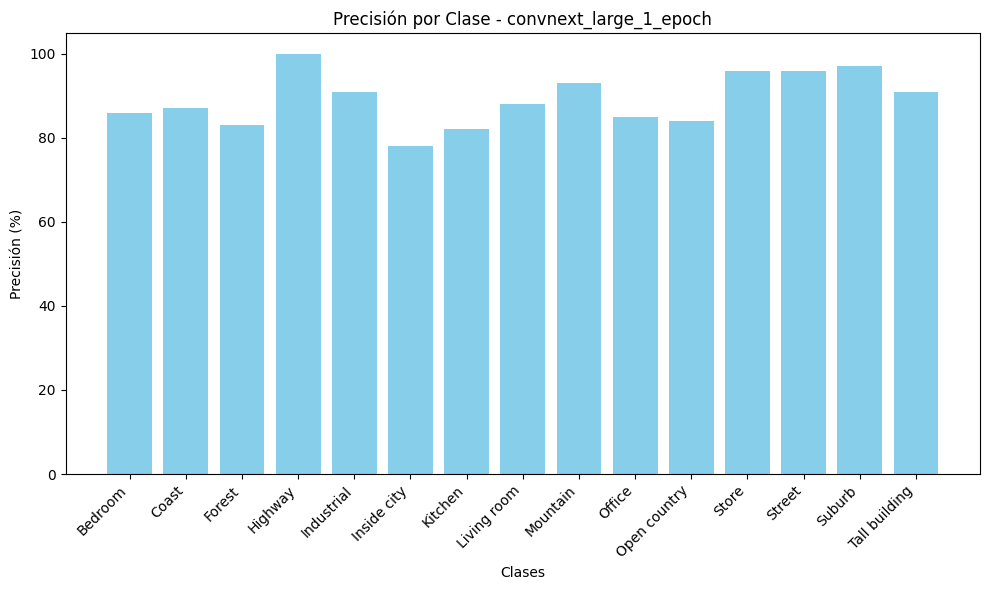


Evaluando el modelo: convnext_large_epoch_3.pt
Cargando el modelo: convnext_large_epoch_3
Loss promedio: 0.0945
Precisión global: 97.40%
Precisión por clase:
Bedroom: 96.00%
Coast: 96.00%
Forest: 96.00%
Highway: 98.00%
Industrial: 95.00%
Inside city: 96.00%
Kitchen: 99.00%
Living room: 97.00%
Mountain: 99.00%
Office: 99.00%
Open country: 94.00%
Store: 98.00%
Street: 100.00%
Suburb: 100.00%
Tall building: 98.00%


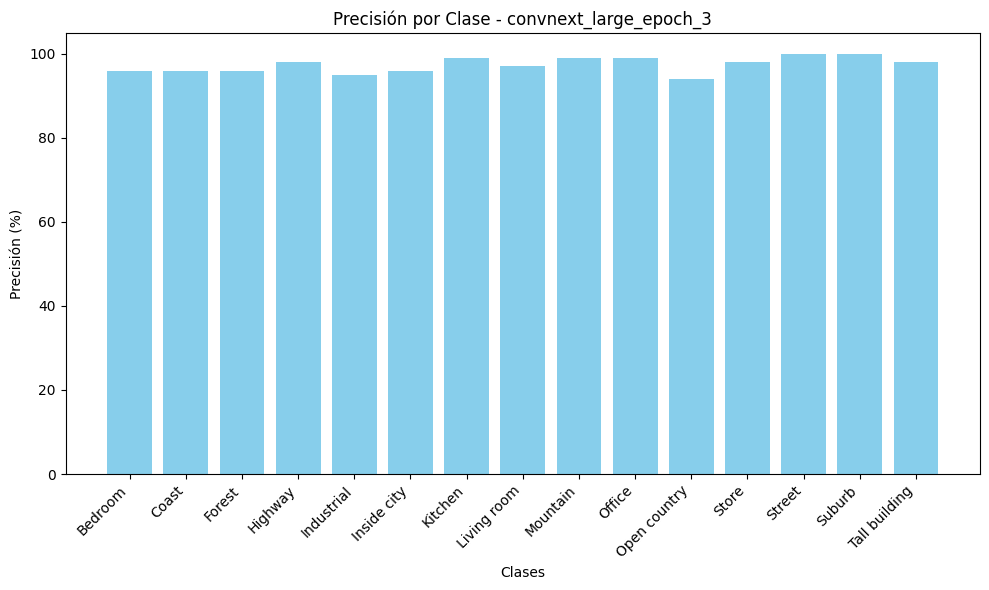


Evaluando el modelo: efficientnet_rank_0.pt
Cargando el modelo: efficientnet_rank_0
Loss promedio: 0.2471
Precisión global: 93.20%
Precisión por clase:
Bedroom: 77.00%
Coast: 98.00%
Forest: 98.00%
Highway: 96.00%
Industrial: 83.00%
Inside city: 93.00%
Kitchen: 92.00%
Living room: 88.00%
Mountain: 100.00%
Office: 97.00%
Open country: 84.00%
Store: 96.00%
Street: 100.00%
Suburb: 99.00%
Tall building: 97.00%


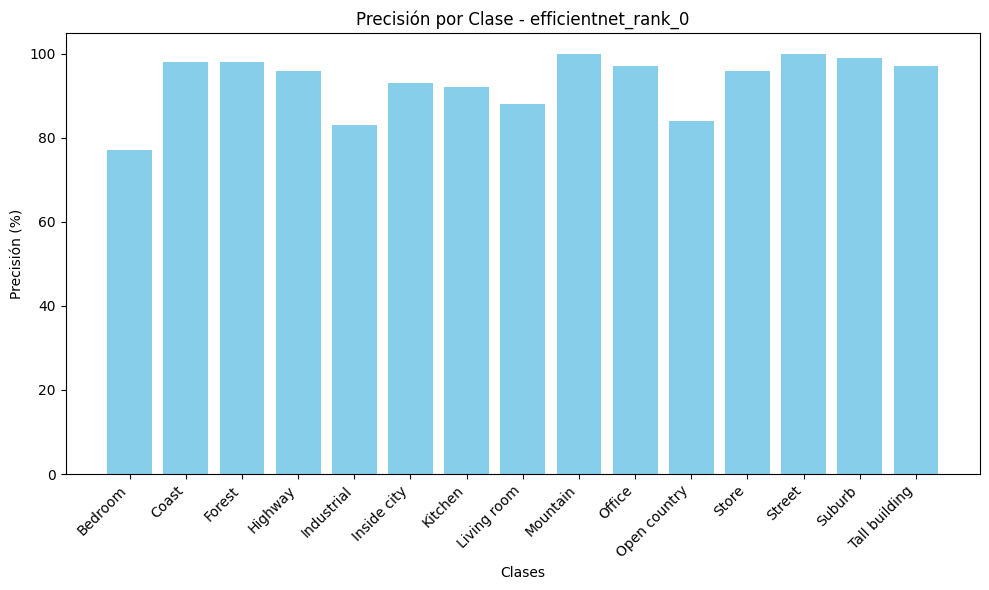


Evaluando el modelo: efficientnet_rank_7.pt
Cargando el modelo: efficientnet_rank_7


Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to C:\Users\pablo/.cache\torch\hub\checkpoints\efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:23<00:00, 11.3MB/s] 


Error al cargar el modelo: Error(s) in loading state_dict for EfficientNet:
	size mismatch for features.0.0.weight: copying a param with shape torch.Size([32, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 3, 3, 3]).
	size mismatch for features.0.1.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.0.1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.0.1.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.0.1.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for features.1.0.block.0.0.weight: copying a param with shape torch.Size([32, 1, 3, 3]) from checkpoint, the shape in current model is to

AttributeError: 'NoneType' object has no attribute 'eval'

In [6]:
# Cargar todos los modelos de la carpeta 'models' y evaluarlos
model_dir = "../models_generator/models/"  # Ruta donde se encuentran los modelos
model_files = [
    f for f in os.listdir(model_dir) if f.endswith(".pt") or f.endswith(".pth")
]  # Archivos con extensión .pt o .pth

# Número de clases (debes ajustarlo a tu dataset)
num_classes = len(class_names)

# Evaluar cada modelo
for model_file in model_files:
    print(f"\nEvaluando el modelo: {model_file}")

    # Cargar el modelo
    model_name = model_file.split(".")[
        0
    ]  # Usamos el nombre del archivo como el nombre del modelo
    model_path = os.path.join(model_dir, model_file)

    # Cargar el modelo con la función load_model
    model = load_model(model_name, model_path, num_classes)

    # Definir la función de pérdida (por ejemplo, cross-entropy)
    criterion = nn.CrossEntropyLoss()

    # Evaluar el modelo
    avg_loss, accuracy, class_accuracies = evaluate(
        model, val_loader, criterion, num_classes
    )

    # Mostrar los resultados
    print(f"Loss promedio: {avg_loss:.4f}")
    print(f"Precisión global: {accuracy:.2f}%")
    print("Precisión por clase:")
    for clase, acc in class_accuracies.items():
        print(f"{clase}: {acc:.2f}%")

    # Visualizar precisión por clase
    accuracies = list(class_accuracies.values())

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, accuracies, color="skyblue")
    plt.xlabel("Clases")
    plt.ylabel("Precisión (%)")
    plt.title(f"Precisión por Clase - {model_name}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [35]:
# Función para mostrar algunas imágenes de ejemplo y sus predicciones
def show_predictions(model, dataloader, num_images=5):
    model.eval()
    images, labels = next(iter(dataloader))
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Mostrar las imágenes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[i].imshow(images[i].permute(1, 2, 0))  # Convertir tensor a imagen
        axes[i].set_title(f"Predicción: {predicted[i].item()}")
        axes[i].axis("off")
    plt.show()

Cargando el modelo: efficientnet_rank_7


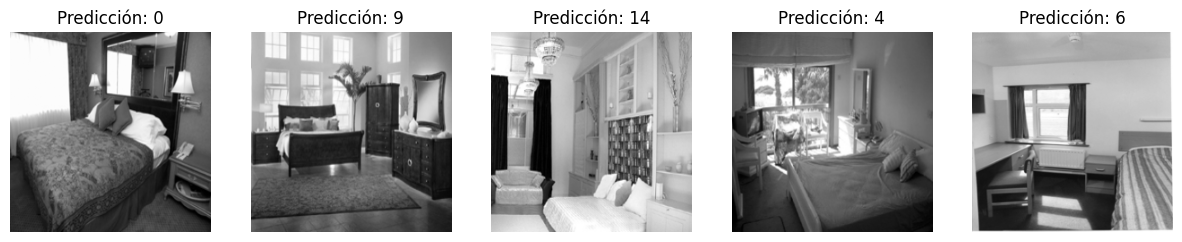

In [36]:
# Mostrar ejemplos de predicciones de uno de los modelos
model = load_model(
    "efficientnet_rank_7",
    "../models_generator/models/efficientnet_rank_7.pt",
    num_classes,
)
show_predictions(model, val_loader, num_images=5)